# Cafe Sales Data Cleaning

## Loading Data

In [7]:
# Loading necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats

In [8]:
# Reading in the data
sales = pd.read_csv(
    r'C:\Users\matth\OneDrive\Projects\Python\Cafe sales\For Github\dirty_cafe_sales.csv')

In [9]:
# Viewing first 10 rows
sales.head(n=10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
6,TXN_4433211,UNKNOWN,3,3.0,9.0,ERROR,Takeaway,2023-10-06
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,UNKNOWN,2023-10-28
8,TXN_4717867,NaN,5,3.0,15.0,NaN,Takeaway,2023-07-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31


## Overview of Data

In [10]:
# Some general information about each column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [11]:
# Number of null values in each column
sales.isna().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [12]:
# Checking for any duplicated entries
len(sales["Transaction ID"].unique())

10000

There doesn't seem to be any duplicates.

It seems as though there are multiple ways of displaying imperfect data. For example, there are "NaN", "UNKNOWN", and "ERROR" entries. Let us look at a few columns to see if there are any more ways of representing this data. 

In [13]:
# Apply unique function to some columns
unique_values = {col: sales[col].unique()
                 for col in ["Quantity", "Payment Method", "Location"]}
for key, value in unique_values.items():
    print(f"{key}: {value}")

Quantity: ['2' '4' '5' '3' '1' 'ERROR' 'UNKNOWN' nan]
Payment Method: ['Credit Card' 'Cash' 'UNKNOWN' 'Digital Wallet' 'ERROR' nan]
Location: ['Takeaway' 'In-store' 'UNKNOWN' nan 'ERROR']


It doesn't seem as though there are any other ways of representing missing data.

## Handling Missing Values

We now want to replace "ERROR" and "UNKNOWN" with "NaN" for all the data, to make manipulations easier. 

In [14]:
# Standardizing the missing and incomplete data
sales = sales.replace(['ERROR', 'UNKNOWN'], np.nan)

We want to do multiple forms of Analysis on this data. We will do some general cleaning, then branch off as needed.

### Quantity, Price Per Unit and Total Spent

We will now convert the data types of "Quantity", "Price Per Unit", and "Total Spent" columns to floats.

In [15]:
# Converting "Quantity" column to float
sales['Quantity'] = sales['Quantity'].astype(float)

In [16]:
# Converting "Price Per Unit" column to float
sales['Price Per Unit'] = sales['Price Per Unit'].astype(float)

In [17]:
# Converting "Total Spent" column to float
sales['Total Spent'] = sales['Total Spent'].astype(float)

We will now fill in the nan values as best we can.

In [18]:
# Equation to fill in "Total Spent"
fill_total_spent = sales['Quantity'] * sales['Price Per Unit']
# Filling in "Total Spent"
sales['Total Spent'] = sales['Total Spent'].fillna(fill_total_spent)

In [19]:
# Equation to fill in "Price Per Unit"
fill_ppu = sales['Total Spent'] / sales['Quantity']
# Filling in "Price Per Unit"
sales['Price Per Unit'] = sales['Price Per Unit'].fillna(fill_ppu)

In [20]:
# Equation to fill in "Quantity"
fill_quantity = sales['Total Spent'] / sales['Price Per Unit']
# Filling in "Quantity"
sales['Quantity'] = sales['Quantity'].fillna(fill_quantity)

We will now drop the nan rows for the three columns because we cannot glean any more information from them.

In [21]:
# Creating list of indices to drop
to_drop = sales[sales['Quantity'].isna() | sales['Price Per Unit'].isna()
                | sales['Total Spent'].isna()].index
to_drop_list = list(to_drop)
len(to_drop_list)

58

In [22]:
# Dropping remaining NaN values from "Total Spent", "Price Per Unit", and "Quantity" columns
sales.drop(to_drop_list, inplace=True)

Quantity, Price Per Unit, and Total Spent columns now have zero null values.

We now proceed to clean the item column.

### Item

#### Looking for Opportunities to Impute

We will be looking for ways to impute item values as much as possible. For example, if a specific price per unit refers to only one item, then we know that any "NaN" item values with this price per unit must be this unique item. Therefore, we can populate the missing values. Let us see if this is the case for any items.

In [23]:
# Getting subset of sales data with Price Per Unit of 1
ppu1 = sales[np.isclose(sales['Price Per Unit'], 1.)]
len(ppu1)

1205

In [24]:
# Getting items corresponding to Price Per Unit of 1
ppu1["Item"].unique()

array(['Cookie', nan], dtype=object)

Since there is a unique item, we can impute.

In [25]:
# Getting subset of sales data with Price Per Unit of 1.5
ppu15 = sales[np.isclose(sales['Price Per Unit'], 1.5)]
len(ppu15)

1199

In [26]:
# Getting items corresponding to Price Per Unit of 1.5
ppu15["Item"].unique()

array([nan, 'Tea'], dtype=object)

Since there is a unique item, we can impute.

In [27]:
# Getting subset of sales data with Price Per Unit of 2
ppu2 = sales[np.isclose(sales['Price Per Unit'], 2.)]
len(ppu2)

1284

In [28]:
# Getting items corresponding to Price Per Unit of 2
ppu2["Item"].unique()

array(['Coffee', nan], dtype=object)

Since there is a unique item, we can impute.

In [29]:
# Getting subset of sales data with Price Per Unit of 3
ppu3 = sales[np.isclose(sales['Price Per Unit'], 3.)]
len(ppu3)

2548

In [30]:
# Getting items corresponding to Price Per Unit of 3
ppu3["Item"].unique()

array(['Cake', nan, 'Juice'], dtype=object)

We see that both cake and juice share a 3.0 price per unit. We can't impute any value here, so we will drop the missing values here.

In [31]:
# Getting subset of sales data with Price Per Unit of 4
ppu4 = sales[np.isclose(sales['Price Per Unit'], 4.)]
len(ppu4)

2438

In [32]:
# Getting items corresponding to Price Per Unit of 4
ppu4["Item"].unique()

array(['Smoothie', 'Sandwich', nan], dtype=object)

We see that both "..." and "..." share a 4.0 price per unit. We can't impute any value here, so we will drop the missing values here.

In [33]:
# Getting subset of sales data with Price Per Unit of 5
ppu5 = sales[np.isclose(sales['Price Per Unit'], 5.)]
len(ppu5)

1268

In [34]:
# Getting items corresponding to Price Per Unit of 5
ppu5["Item"].unique()

array(['Salad', nan], dtype=object)

Since there is a unique item, we can impute.

#### Imputing

In [35]:
# Imputing for Price Per Unit of 1.0
sales.loc[np.isclose(sales['Price Per Unit'], 1.), "Item"] = "Cookie"

In [36]:
# Imputing for Price Per Unit of 1.5
sales.loc[np.isclose(sales['Price Per Unit'], 1.5), "Item"] = "Tea"

In [37]:
# Imputing for Price Per Unit of 2.0
sales.loc[np.isclose(sales['Price Per Unit'], 2.), "Item"] = "Coffee"

In [38]:
# Imputing for Price Per Unit of 5.0
sales.loc[np.isclose(sales['Price Per Unit'], 5.), "Item"] = "Salad"

#### Dropping values which cannot be imputed 

In [39]:
# Creating list of NaN values to drop corresponding to Price Per Unit of 3.0
ppu3drop = sales.loc[np.isclose(
    sales['Price Per Unit'], 3.) & sales["Item"].isna()].index

ppu3droplist = list(ppu3drop)

len(ppu3droplist)

247

In [40]:
# Dropping for Price Per Unit of 3.0
sales.drop(ppu3droplist, inplace=True)

In [41]:
# Creating list of NaN values to drop corresponding to Price Per Unit of 4.0
ppu4drop = sales.loc[np.isclose(
    sales['Price Per Unit'], 4.) & sales["Item"].isna()].index

ppu4droplist = list(ppu4drop)

len(ppu4droplist)

227

In [42]:
# Dropping for Price Per Unit of 4.0
sales.drop(ppu4droplist, inplace=True)

## Other Adjustments to Sales Data

The last thing we want to do with this sales dataset is convert the quantity column to an integer data type.

In [43]:
# Converting "Quantity" column to integer type
sales["Quantity"] = sales["Quantity"].astype(int)

In [44]:
# Updated general information about columns
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9468 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9468 non-null   object 
 1   Item              9468 non-null   object 
 2   Quantity          9468 non-null   int32  
 3   Price Per Unit    9468 non-null   float64
 4   Total Spent       9468 non-null   float64
 5   Payment Method    6454 non-null   object 
 6   Location          5717 non-null   object 
 7   Transaction Date  9035 non-null   object 
dtypes: float64(2), int32(1), object(5)
memory usage: 628.7+ KB


In [45]:
# Updated null values
sales.isna().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3014
Location            3751
Transaction Date     433
dtype: int64

In [46]:
# Updated first 10 rows
sales.head(n=10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,NaN,NaN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,NaN,2023-10-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31
10,TXN_2548360,Salad,5,5.0,25.0,Cash,Takeaway,2023-11-07
11,TXN_3051279,Sandwich,2,4.0,8.0,Credit Card,Takeaway,NaN


At this point, we have cleaned the sales data enough to do some analysis on it. We will create a few different copies of the dataset for different purposes.

## Branching out Sales Data

### Creating Copies of Sales Data

In [47]:
# Create copies of semi-clean data to further clean in different ways for analysis
items = sales.copy()
payment_methods = sales.copy()
locations = sales.copy()
dates = sales.copy()

### Focus on Items

We now move on to the items table to clean it.

#### Overview of Table

In [48]:

# Overview of items table
items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9468 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9468 non-null   object 
 1   Item              9468 non-null   object 
 2   Quantity          9468 non-null   int32  
 3   Price Per Unit    9468 non-null   float64
 4   Total Spent       9468 non-null   float64
 5   Payment Method    6454 non-null   object 
 6   Location          5717 non-null   object 
 7   Transaction Date  9035 non-null   object 
dtypes: float64(2), int32(1), object(5)
memory usage: 628.7+ KB


In [49]:
# Null values in items table
items.isna().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3014
Location            3751
Transaction Date     433
dtype: int64

In [50]:
# First 10 rows of items table
items.head(n=10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,NaN,NaN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,NaN,2023-10-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31
10,TXN_2548360,Salad,5,5.0,25.0,Cash,Takeaway,2023-11-07
11,TXN_3051279,Sandwich,2,4.0,8.0,Credit Card,Takeaway,NaN


### Focus on Payment Methods

We now move on to the payment methods table to clean it.

#### Overview of Table

In [51]:
# Overview of payment methods table
payment_methods.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9468 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9468 non-null   object 
 1   Item              9468 non-null   object 
 2   Quantity          9468 non-null   int32  
 3   Price Per Unit    9468 non-null   float64
 4   Total Spent       9468 non-null   float64
 5   Payment Method    6454 non-null   object 
 6   Location          5717 non-null   object 
 7   Transaction Date  9035 non-null   object 
dtypes: float64(2), int32(1), object(5)
memory usage: 628.7+ KB


In [52]:
# Null values in payment methods table
payment_methods.isna().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3014
Location            3751
Transaction Date     433
dtype: int64

In [53]:
# First 10 rows of payment methods table
payment_methods.head(n=10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,NaN,NaN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,NaN,2023-10-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31
10,TXN_2548360,Salad,5,5.0,25.0,Cash,Takeaway,2023-11-07
11,TXN_3051279,Sandwich,2,4.0,8.0,Credit Card,Takeaway,NaN


#### Removing Missing Values

In [54]:
# Remove null values
payment_methods = payment_methods[payment_methods["Payment Method"].notna()]

### Focus on Location

We now move on to the location table to clean it.

#### Overview of Table

In [55]:
# Overview of locations table
locations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9468 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9468 non-null   object 
 1   Item              9468 non-null   object 
 2   Quantity          9468 non-null   int32  
 3   Price Per Unit    9468 non-null   float64
 4   Total Spent       9468 non-null   float64
 5   Payment Method    6454 non-null   object 
 6   Location          5717 non-null   object 
 7   Transaction Date  9035 non-null   object 
dtypes: float64(2), int32(1), object(5)
memory usage: 628.7+ KB


In [56]:
# Null values in locations table
locations.isna().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3014
Location            3751
Transaction Date     433
dtype: int64

In [57]:
# First 10 rows of locations table
locations.head(n=10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,NaN,NaN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,NaN,2023-10-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31
10,TXN_2548360,Salad,5,5.0,25.0,Cash,Takeaway,2023-11-07
11,TXN_3051279,Sandwich,2,4.0,8.0,Credit Card,Takeaway,NaN


#### Removing Missing Values

In [58]:
# Remove null values
locations = locations[locations["Location"].notna()]

### Focus on Dates

We now move on to the dates table to clean it.

#### Overview of Table

In [59]:
# Overview of dates table
dates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9468 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9468 non-null   object 
 1   Item              9468 non-null   object 
 2   Quantity          9468 non-null   int32  
 3   Price Per Unit    9468 non-null   float64
 4   Total Spent       9468 non-null   float64
 5   Payment Method    6454 non-null   object 
 6   Location          5717 non-null   object 
 7   Transaction Date  9035 non-null   object 
dtypes: float64(2), int32(1), object(5)
memory usage: 628.7+ KB


In [60]:
# Null values in dates table
dates.isna().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3014
Location            3751
Transaction Date     433
dtype: int64

In [61]:
# First 10 rows of dates table
dates.head(n=10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,NaN,NaN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,NaN,2023-10-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31
10,TXN_2548360,Salad,5,5.0,25.0,Cash,Takeaway,2023-11-07
11,TXN_3051279,Sandwich,2,4.0,8.0,Credit Card,Takeaway,NaN


#### Removing Missing Values

In [62]:
# Remove null values
dates = dates[dates["Transaction Date"].notna()]

# Generating Insights

## Total Spent column

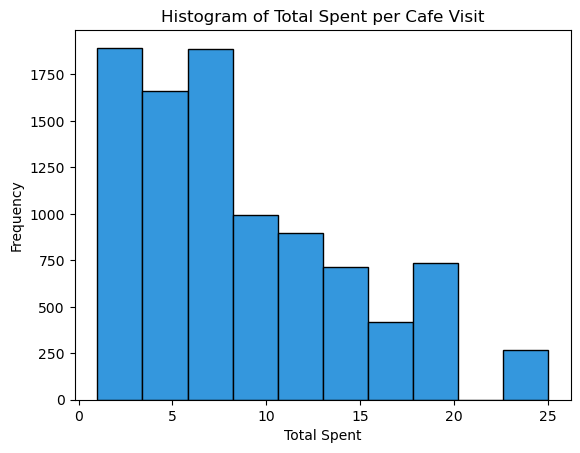

In [63]:
# Histogram of Total Spent
x = items["Total Spent"]
plt.hist(x, edgecolor="black", color="#3497DD")
plt.xlabel("Total Spent")
plt.ylabel("Frequency")
plt.title("Histogram of Total Spent per Cafe Visit")
plt.show()

We see the majority of purchases are less than or equal to $10. 

## Items

We will now look at the total quantity of each item purchased through a pie chart. 

In [64]:
# Selecting relevant columns for pie chart
items_pie = items.loc[:, ["Item", "Quantity", "Total Spent"]]

In [65]:
# Overview of selected columns
items_pie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9468 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Item         9468 non-null   object 
 1   Quantity     9468 non-null   int32  
 2   Total Spent  9468 non-null   float64
dtypes: float64(1), int32(1), object(1)
memory usage: 258.9+ KB


In [66]:
# Group by item
items_pie_grp = items_pie.groupby("Item", as_index=False)

In [67]:
# Sum Quantity and Total Spent for each item
items_sum = items_pie_grp.sum()
items_sum

,Item,Quantity,Total Spent
0,Cake,3459,10377.0
1,Coffee,3897,7794.0
2,Cookie,3585,3585.0
3,Juice,3503,10509.0
4,Salad,3813,19065.0
5,Sandwich,3411,13644.0
6,Smoothie,3324,13296.0
7,Tea,3629,5443.5


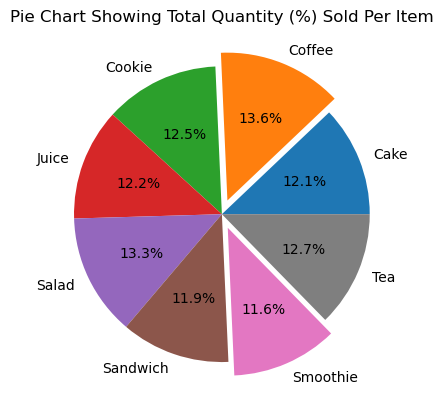

In [68]:
# Pie chart of quantity for the items
x = items_sum["Quantity"]
labels = items_sum["Item"]
explode = [0, 0.1, 0, 0, 0, 0, 0.1, 0]
plt.pie(x=x, labels=labels, autopct='%1.1f%%', explode=explode)
plt.title("Pie Chart Showing Total Quantity (%) Sold Per Item")
plt.show()

We see that all items get ordered a fairly even amount, with coffee being the most ordered by a bit, and smoothie the least ordered by a bit.

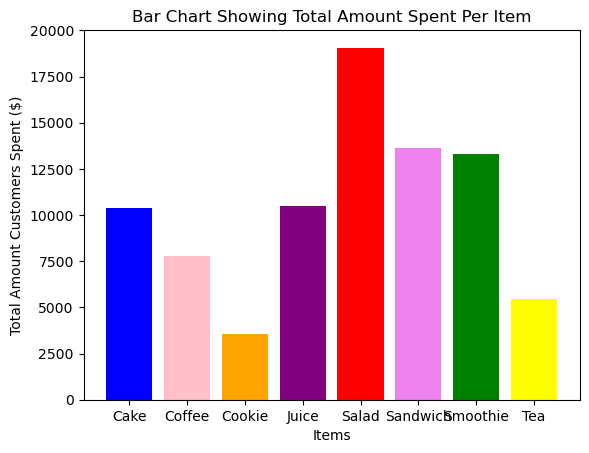

In [69]:
# Bar chart of total spent for the items
values = items_sum["Total Spent"]
categories = items_sum["Item"]
colors = ["blue", "pink", "orange", "purple",
          "red", "violet", "green", "yellow"]
plt.bar(categories, values, color=colors)
plt.xlabel("Items")
plt.ylabel("Total Amount Customers Spent ($)")
plt.title("Bar Chart Showing Total Amount Spent Per Item")
plt.show()

We see there is more of a difference in the total amount of money spent for each item. Salad takes a significant share and has the plurality. Whereas, cookies contribute the lowest toward the total amount spent. 

## Payment Methods

Moving on to payment method.

In [70]:
# Checking unique values
payment_unique = payment_methods["Payment Method"].unique()
payment_unique

array(['Credit Card', 'Cash', 'Digital Wallet'], dtype=object)

In [71]:
# Checking how many used Credit Card
len(payment_methods[payment_methods["Payment Method"] == "Credit Card"])

2147

In [72]:
# Checking how many used Cash
len(payment_methods[payment_methods["Payment Method"] == "Cash"])

2137

In [73]:
# Checking how many used Digital Wallet
len(payment_methods[payment_methods["Payment Method"] == "Digital Wallet"])

2170

In [74]:
# Dictionary mapping the method to the times each was used
method_count = {col: payment_methods["Payment Method"].value_counts()[
    col] for col in payment_unique}
method_count

{'Credit Card': 2147, 'Cash': 2137, 'Digital Wallet': 2170}

In [75]:
# Creating a list of methods and times used
method = list(method_count.keys())
count = list(method_count.values())
print(method, count)

['Credit Card', 'Cash', 'Digital Wallet'] [2147, 2137, 2170]


In [76]:
# Assigning each list to a dictionary
method_count_dict = {"Payment Method": method, "Times Used": count}
method_count_dict

{'Payment Method': ['Credit Card', 'Cash', 'Digital Wallet'],
 'Times Used': [2147, 2137, 2170]}

In [77]:
# Creating a data frame to store these values
method_count_df = pd.DataFrame(method_count_dict)
method_count_df

,Payment Method,Times Used
0,Credit Card,2147
1,Cash,2137
2,Digital Wallet,2170


In [78]:
# Group by method to get total spent
payment_methods_spent = payment_methods.loc[:, [
    "Payment Method", "Total Spent"]]
method_grp = payment_methods_spent.groupby("Payment Method", as_index=False)
method_total_spent = method_grp.sum()
method_total_spent

,Payment Method,Total Spent
0,Cash,19242.5
1,Credit Card,19176.5
2,Digital Wallet,19155.5


In [79]:
# Showing a table with times used and the amount of money generated by each payment method
total_spent_count = pd.merge(
    method_count_df, method_total_spent, on="Payment Method")
total_spent_count

,Payment Method,Times Used,Total Spent
0,Credit Card,2147,19176.5
1,Cash,2137,19242.5
2,Digital Wallet,2170,19155.5


We can see customers use the three payment methods an equal amount, and the amount of money customers spend using each payment method is also roughly equal. These are all important avenues of payment to maintain. 

## Location

In [80]:
# Obtaining the total times each location was used
location_count = locations["Location"].value_counts()
location_count

Location
Takeaway    2859
In-store    2858
Name: count, dtype: int64

In [81]:
# List of locations, preserving order
location_list = list(location_count.index)
location_list

['Takeaway', 'In-store']

In [82]:
# Times each location was used, preserving order
times_used = list(location_count)
times_used

[2859, 2858]

In [83]:
# Dictionary of locations and times each was used
locations_dict = {"Location": location_list, "Times Used": times_used}
locations_dict

{'Location': ['Takeaway', 'In-store'], 'Times Used': [2859, 2858]}

In [84]:
# data frame of above dictionary
location_count_df = pd.DataFrame(locations_dict)
location_count_df

,Location,Times Used
0,Takeaway,2859
1,In-store,2858


In [85]:
# Data frame of total spent per location
location_total_spent = locations.loc[:, ["Location", "Total Spent"]]
locations_grp = location_total_spent.groupby("Location", as_index=False)
location_total_spent_df = locations_grp.sum()
location_total_spent_df

,Location,Total Spent
0,In-store,25620.0
1,Takeaway,24790.5


In [86]:
# Table of times used and total spent per location
location_count_spent = pd.merge(
    location_count_df, location_total_spent_df, on="Location")
location_count_spent

,Location,Times Used,Total Spent
0,Takeaway,2859,24790.5
1,In-store,2858,25620.0


We see that each location was used an almost equal amount of times, as well as the total amount spent per location was very similar, with "In-store" being slightly higher.

## Time Series

We will now investigate the total spent by customers at the cafe per day and see if we can fit a model to make predictions. 

In [87]:
# Selecting necessary columns for time series analysis
time_data = dates.loc[:, ["Transaction Date", "Total Spent"]]
time_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9035 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction Date  9035 non-null   object 
 1   Total Spent       9035 non-null   float64
dtypes: float64(1), object(1)
memory usage: 211.8+ KB


In [88]:
# Converting "Transaction Date" to a datetime object
time_data["Transaction Date"] = pd.to_datetime(time_data["Transaction Date"])

In [89]:
# Updated column information
time_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9035 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction Date  9035 non-null   datetime64[ns]
 1   Total Spent       9035 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 211.8 KB


In [90]:
# Setting "Transaction date" as the index
time_data.set_index('Transaction Date', inplace=True)

We now want to analyze the daily total spent data for the year. The hope is to be able to find a model to fit the data.

In [91]:
# Grouping the Total Spent data by day
daily_data = time_data.resample('D').sum()
print(daily_data)
print(f"max total spent: {max(daily_data["Total Spent"])}")
print(f"Number of rows: {len(daily_data)}")

                  Total Spent
Transaction Date             
2023-01-01              164.0
2023-01-02              169.5
2023-01-03              182.0
2023-01-04              239.5
2023-01-05              340.5
...                       ...
2023-12-27              197.0
2023-12-28              167.0
2023-12-29              160.5
2023-12-30              156.0
2023-12-31              155.0

[365 rows x 1 columns]
max total spent: 371.5
Number of rows: 365


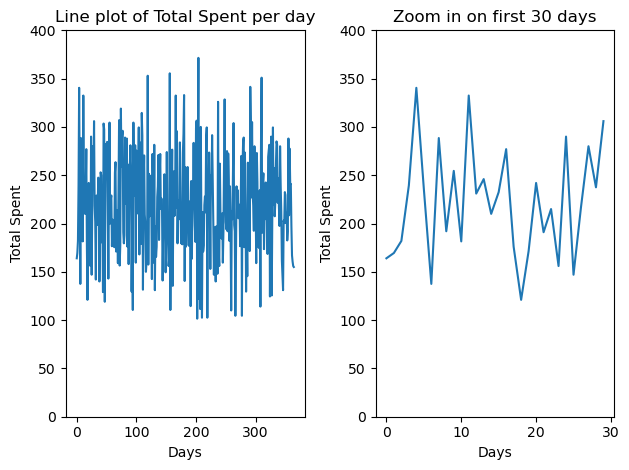

In [92]:
# Line plot of daily Total Spent data
count = np.arange(len(daily_data))
plt.subplot(1, 2, 1)
plt.plot(count, daily_data["Total Spent"])
plt.xlabel("Days")
plt.ylabel("Total Spent")
plt.ylim(0, 400)
plt.title("Line plot of Total Spent per day")

# Line plot of segment of daily Total Spent data for better visuals
subset = 30
count_subset = np.arange(subset)
plt.subplot(1, 2, 2)
plt.plot(count_subset, daily_data.iloc[:subset])
plt.ylim(0, 400)
plt.xlabel("Days")
plt.ylabel("Total Spent")
plt.title("Zoom in on first 30 days")

plt.tight_layout()
plt.show()

The data seems to be fairly random, with no clear pattern. We will confirm with plots of ACF and PACF, and after a formal test of stationarity (no trend or season). 

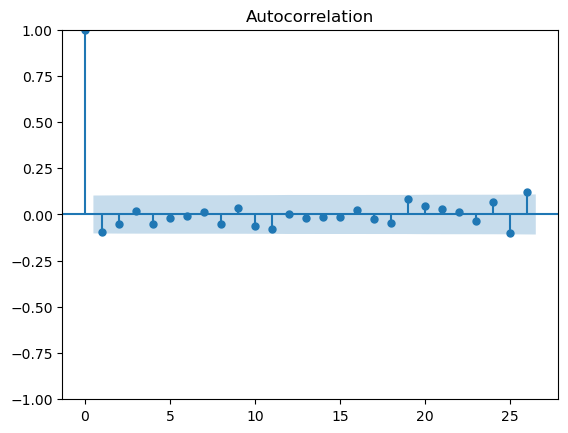

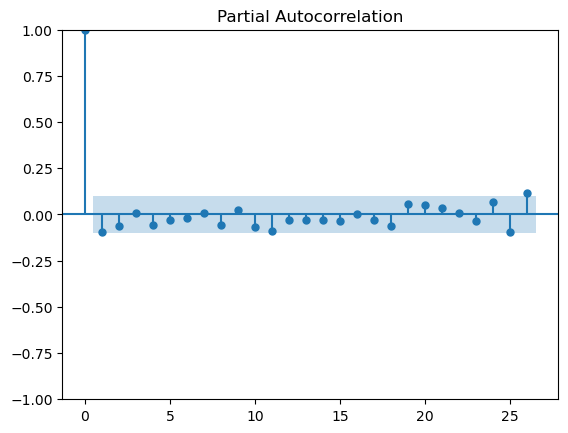

In [93]:
# ACF and PACF
plot_acf(daily_data["Total Spent"])
plot_pacf(daily_data["Total Spent"])
plt.show()

In [94]:
# Augmented Dickey-Fuller test of stationarity
result = adfuller(daily_data["Total Spent"])
print(f"ADF test statistic: {result[0]}")
print(f"ADF p-value: {result[1]}")

ADF test statistic: -20.867866180045162
ADF p-value: 0.0


Very clear the data is stationary. We can now move on to proposing a model for the data.

In [95]:
# Calculating mean and standard deviation of daily data
daily_data_mean = np.mean(daily_data)
daily_data_std = np.std(daily_data["Total Spent"])
print(f"daily data mean = {daily_data_mean}")
print(f"daily data standard deviation = {daily_data_std}")

daily data mean = 218.67397260273972
daily data standard deviation = 53.625763148504696


In [96]:
# Generating a random sample from a Normal distribution with the above mean and standard deviation
np.random.seed(1)
sample_normal = np.random.normal(
    loc=daily_data_mean, scale=daily_data_std, size=365)

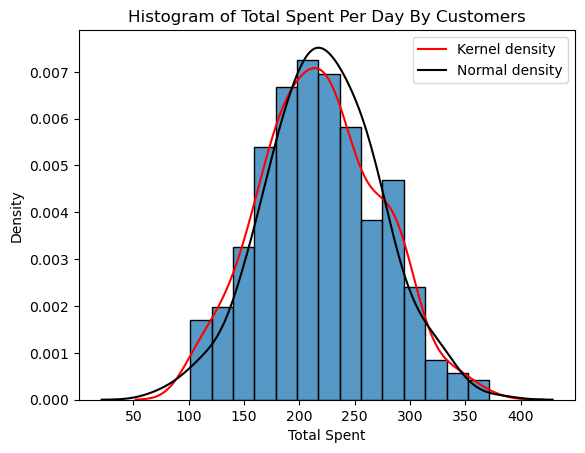

In [97]:
# Histogram of total amount of money spent per day by customers overlaid with KDE and
# Normal density function
sns.histplot(daily_data["Total Spent"], kde=False, stat='density')
sns.kdeplot(daily_data["Total Spent"], color='red', label="Kernel density")
sns.kdeplot(sample_normal, color='black', label="Normal density")
plt.legend()
plt.title("Histogram of Total Spent Per Day By Customers")
plt.show()

We will now plot a qq plot and perform the following tests:
1. Kolmogorov-Smirnov Test
2. Shapiro-Wilk Test
3. Anderson-Darling Test

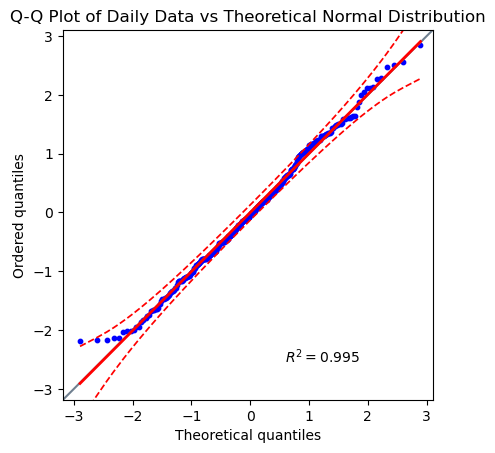

In [98]:
# qq plot of daily data
ax = pg.qqplot(daily_data["Total Spent"], dist='norm', confidence=0.95, s=10)
plt.title("Q-Q Plot of Daily Data vs Theoretical Normal Distribution")
plt.show()

Based on the histogram and q-q plot, it seems as though the daily total spent data fits well with a Normal Distribution with mean 218.67 and standard deviation 53.63. We will now perform some formal tests to further verify our claims. 

In [99]:
# Standardizing data for Normal tests
standardized_data = (daily_data["Total Spent"] -
                     daily_data_mean) / daily_data_std

# Kolmogorov-Smirnov test
statistic, p_value = stats.kstest(standardized_data, 'norm')
print(f"KS test statistic: {statistic}")
print(f"KS p-value: {p_value}")
if p_value > 0.05:
    print("At a 5% significance level, there is no evidence to reject the null hypothesis that the data is Normally distributed\nPassed")
else:
    print("At a 5% significance level, there is evidence to reject the null hypothesis that the data is Normally distributed\nFailed")

print()

# Shapiro-Wilk test
statistic, p_value = stats.shapiro(standardized_data)
print(f"Shapiro test statistic: {statistic}")
print(f"Shapiro p-value: {p_value}")
if p_value > 0.05:
    print("At a 5% significance level, there is no evidence to reject the null hypothesis that the data is Normally distributed\nPassed")
else:
    print("At a 5% significance level, there is evidence to reject the null hypothesis that the data is Normally distributed\nFailed")

print()

# Anderson-Darling test
result = stats.anderson(standardized_data)
statistic, critical_values, significance_levels = result
print(f"AD test statistic: {statistic}")
print(f"AD critical values: {critical_values}")
print(f"AD significance levels: {significance_levels}")
for i, cv in enumerate(critical_values):
    sl = significance_levels[i]
    if statistic < cv:
        print(f"At a {sl}% significance level, there is no evidence to reject the null hypothesis that the data is Normally distributed\nPassed")
    else:
        print(f"At a {sl}% significance level, there is evidence to reject the null hypothesis that the data is Normally distributed\nFailed")

KS test statistic: 0.03724876954723155
KS p-value: 0.6774912622597136
At a 5% significance level, there is no evidence to reject the null hypothesis that the data is Normally distributed
Passed

Shapiro test statistic: 0.9935908599042053
Shapiro p-value: 0.12478698012875206
At a 5% significance level, there is no evidence to reject the null hypothesis that the data is Normally distributed
Passed

AD test statistic: 0.4436123355283712
AD critical values: [0.57  0.649 0.779 0.908 1.08 ]
AD significance levels: [15.  10.   5.   2.5  1. ]
At a 15.0% significance level, there is no evidence to reject the null hypothesis that the data is Normally distributed
Passed
At a 10.0% significance level, there is no evidence to reject the null hypothesis that the data is Normally distributed
Passed
At a 5.0% significance level, there is no evidence to reject the null hypothesis that the data is Normally distributed
Passed
At a 2.5% significance level, there is no evidence to reject the null hypothesi

Based on the three formal tests of Normality, we see there no evidence to suggest the data does not follow a Normal distribution.

Using both the graphical tests and the formal tests, we can say that the daily sales data can be modelled by a Normal distribution with mean 218.67 and standard deviation 53.63. 

Normally, with time series data, we may want to try to forecast future sales. However, since the sales data seems to be white noise, it does not make sense to try to forecast it. We will stop our analysis here.

# Final Thoughts

The above work has provided valuable insights into the cafe sales data in a few general ways. Firstly, we cleaned the data to a point where analysis could be conducted. Next, we investigated the distribution of quantities of each item sold, and the total amount of money spent on each item for the year. We found that each item was purchased a similar amount of times, however, the salad generated the most revenue and cookies the least. We then investigated the payment methods used and the revenue from each method. All three methods had similar results. We then looked at the location the customers chose to purchase their products, the frequency and revenue from each location. Both locations were very similar, with in-store making a bit more revenue than takeaway. Finally, we performed a time series analysis on the sales per day. We found through graphical and formal tests, that a Normal distribution with mean 218.67 and standard deviation 53.63 is a reasonable model for the sales data. As far as future implications, generally, we can hypothesize that the future data will continue to follow the above Normal distribution and corporate decisions can be made with this model in mind. It will be interesting to see if 2024 continues this distribution of sales. The sales have been generally constant throughout 2023. This may or may not be desirable to management. 

# Saving the Datasets to Excel Files

In [100]:
# Save the semi-clean starting point to excel
sales.to_excel("clean_cafe_sales.xlsx", index=False)

In [101]:
# Save the data tailored to items to excel
items.to_excel("clean_cafe_items.xlsx", index=False)

In [102]:
# Save the data tailored to payment methods to excel
payment_methods.to_excel("clean_cafe_payment.xlsx", index=False)

In [103]:
# Save the data tailored to locations to excel
locations.to_excel("clean_cafe_locations.xlsx", index=False)

In [104]:
# Save the data tailored to dates to excel
dates.to_excel("clean_cafe_dates.xlsx", index=False)